In [1]:
# import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
import pandas as pd

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import datetime
import pickle
from nltk.corpus import stopwords
import re
import regex
import string
from urllib.parse import urlparse

In [2]:
# import ML libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [27]:
# import evaluation libraries
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
# load required models
from ipynb.fs.defs.models import FFNetworkBertEmbedding

In [7]:
# load required test datasets
from ipynb.fs.defs.datasets import BertProcessedTitleEmbeddingDataset

In [8]:
# import testing data
req_cols_without_url = ["title", "text", "time"]
cutoff = 20
batch_size = 1
with open("../data/data_test", "rb") as fb:
    testing_data = pickle.load(fb)
testing_data_indexed = testing_data.reset_index(drop=True)
testing_scores = testing_data_indexed.score
testing_data_indexed = testing_data_indexed[req_cols_without_url]
testing_data_indexed.title = testing_data_indexed.title.fillna("")
testing_data_indexed.text = testing_data_indexed.text.fillna("")
bert_proc_embedding_dataset_test = BertProcessedTitleEmbeddingDataset(testing_data_indexed, testing_scores, cutoff)
test_loader_processed_bert_unweighted = torch.utils.data.DataLoader(dataset=bert_proc_embedding_dataset_test, batch_size=batch_size, shuffle=True)

In [9]:
# define functions for plotting losses
def plot_losses(losses):
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.show()

def plot_losses_log(losses):
    plt.figure(figsize=(20, 10))
    plt.plot(np.log(np.arange(len(losses))), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.show()

In [28]:
# define functions for plotting confusion matrix statistics
def plot_classification_metrics(labels, predictions):

    # define and plot confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)
    display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not popular", "popular"])
    display.plot()
    plt.show()

    # plot ROC and calculate AUC
    fpr, tpr, _ = metrics.roc_curve(labels, predictions)
    auc = metrics.roc_auc_score(labels, predictions)
    plt.plot(fpr, tpr, label="AUC: "+str(auc))
    plt.xlabel("False Postitive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [10]:
def evaluate_model(loader, model, loss_func, device):
    predictions = []
    labels = []
    losses = []
    for index, batch in enumerate(loader):
        embedding, score = batch

        # make sure data is on device
        embedding = embedding.to(device)
        scores = score.to(device)

        # get prediction
        preds = model(embedding)

        # get loss
        loss = loss_func(preds, scores.float().unsqueeze(1))

        # add data to outputs
        predictions.append(preds)
        labels.append(scores)
        losses.append(loss)
    
    return (predictions, labels, losses)

In [12]:
# define loss function
loss_func = nn.BCEWithLogitsLoss()

In [11]:
# load models
bert_model = FFNetworkBertEmbedding(1)
bert_model.load_state_dict(torch.load("bert_model_best_2.pth"))
bert_model.eval()

FFNetworkBertEmbedding(
  (hidden): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=900, bias=True)
    (5): ReLU()
    (6): Linear(in_features=900, out_features=800, bias=True)
    (7): ReLU()
    (8): Linear(in_features=800, out_features=700, bias=True)
    (9): ReLU()
    (10): Linear(in_features=700, out_features=600, bias=True)
    (11): ReLU()
    (12): Linear(in_features=600, out_features=300, bias=True)
    (13): ReLU()
    (14): Linear(in_features=300, out_features=128, bias=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [13]:
eval_1 = evaluate_model(test_loader_processed_bert_unweighted, bert_model, loss_func, "cpu")

In [23]:
t = eval_1[0][0]
print(t)
print(t.detach().squeeze(1))

tensor([[-2.4406]], grad_fn=<AddmmBackward0>)
tensor([-2.4406])


C:\Users\Ethan\AppData\Local\Temp\ipykernel_13648\354546842.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(len(losses))), losses)


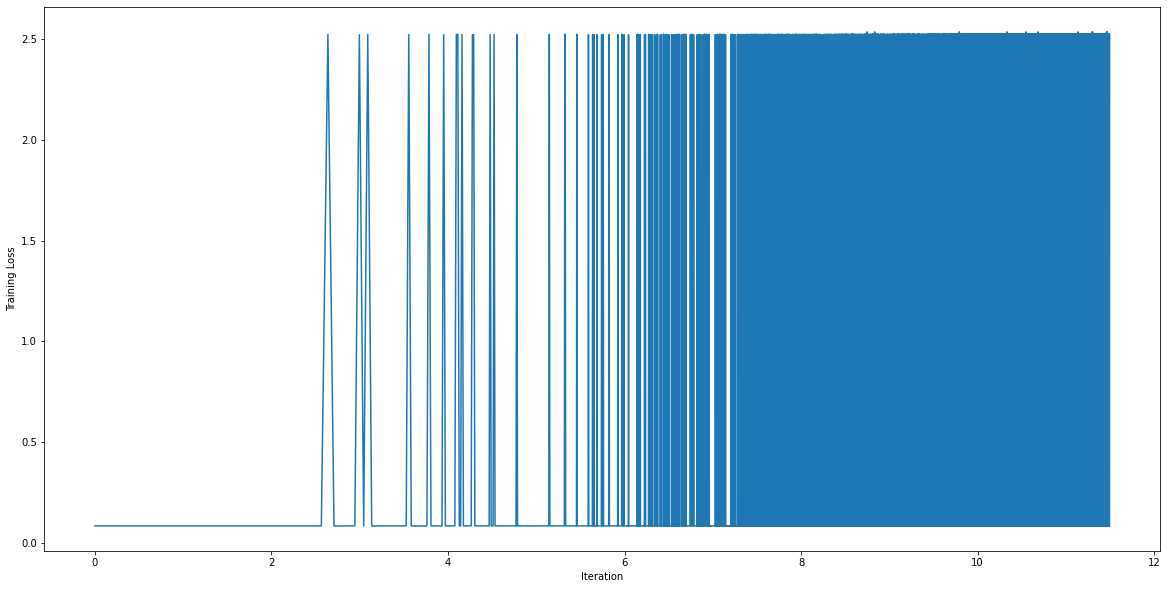

In [62]:
preds, labels, losses = eval_1
preds_2 = [0 if nn.Sigmoid()(pred.detach().squeeze(1)) < 0.5 else 1 for pred in preds]
labels_2 = [label.detach().item() for label in labels]
losses_2 = [loss.detach() for loss in losses]
plot_losses_log(losses_2)

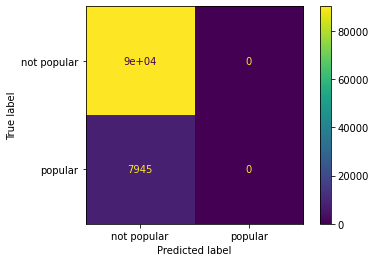

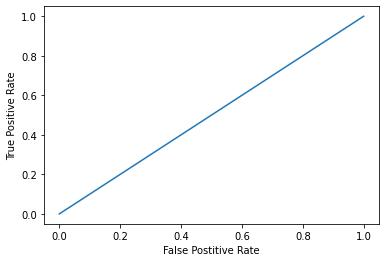

In [63]:
plot_classification_metrics(labels_2, preds_2)